## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem

## tfidf
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn import feature_selection
from sklearn.feature_selection import chi2
#from sklearn.feature_selection import SelectKBest


%matplotlib inline

In [3]:
df = pd.read_csv("./content/train_dataset_train.csv")

In [4]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/helgi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/helgi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import re
cleaner = re.compile('<.*?>|\&nbsp;')
def cleanhtml(income):
    cleantext = re.sub(cleaner, ' ', income)
    return cleantext

def parse_date(income):
  date = re.sub(r"[0-9]{1,2}\.[0-9]{1,2}(\.[0-9]{2,4}){0,1}", " DATE ", income)
  return date

def mark_numbers(income):
  date = re.sub(r"[0-9]+", " NUM ", income)
  return date


df['plain'] = df["Текст Сообщения"].apply(lambda str: cleanhtml(str))

In [6]:
df['plain']

0       Помогите начальник Льговского рэс не реагирует...
1        По фасаду дома по адресу ул. Урицкого 22 прох...
2       Агресивные собаки. На радуге там стая из подро...
3        На пересечении  улиц Сосновская и Береговая  ...
4         Здравствуйте! Рядом с домом 1 «А» по улице С...
                              ...                        
1995     22.12.21 в вечернее время появилась вонь от Г...
1996     Добрый день! Хочу сообщить о такой проблеме -...
1997    Состоят 3 засохшие дерева (2 большие  берёзы и...
1998    Пожалуйста роман Владимирович, в скором времен...
1999     Сдан ПЦР-тест 29.10.2021г., но результат тест...
Name: plain, Length: 2000, dtype: object

In [7]:
df['text'] = df['plain'].map(lambda str: str.lower())
#df['text'] = df["text"].apply(lambda str: parse_date(str))
#df['text'] = df["text"].apply(lambda str: mark_numbers(str))

In [8]:
mystem = Mystem()
df['text'] = df['text'].apply(lambda str: mystem.lemmatize(str))

In [8]:
#df['text'] = df["text"].apply(lambda str: nltk.tokenize.word_tokenize(str))
#df['text'] = df['text'].apply(lambda str: [morph.parse(token)[0].normal_form for token in str])

In [9]:
import string
df['text'] = df['text'].map(lambda str: [token for token in str if token not in string.punctuation])

In [10]:
df['text'] = df['text'].map(lambda str: [token for token in str if token not in nltk.corpus.stopwords.words("russian")])

In [11]:
df['text'] = df['text'].map(lambda str: [token for token in str if token.isalpha()])

In [12]:
df['text'] = df['text'].map(lambda str:' '.join(str))

In [13]:
df.text

0       помогать начальник льговский рэс реагировать ж...
1       фасад дом адрес ул урицкий проходить труба газ...
2       агресивный собака радуга стая подрастать щенок...
3       пересечение улица сосновский береговой завалив...
4       здравствовать рядом дом улица светлый вне прид...
                              ...                        
1995        вечерний время появляться вонь грибной радуга
1996    добрый день хотеть сообщать проблема возле наш...
1997    состоять засыхать дерево большой береза дерево...
1998    пожалуйста роман владимирович скорый время д к...
1999    сдавать пцр тест результат тест портал госуслу...
Name: text, Length: 2000, dtype: object

In [14]:
#count_vectorizer = CountVectorizer(ngram_range=[1,3], analyzer='char', binary=False, tokenizer=str.split)
#count_vectorizer = CountVectorizer(ngram_range=[1,3], analyzer='char', binary=False, tokenizer=nltk.tokenize.word_tokenize)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [15]:
bag_of_words = tfidf_vectorizer.fit_transform(df["text"])
#bag_of_words = count_vectorizer.fit_transform(df["Текст Сообщения"])
#bag_of_words = count_vectorizer.fit_transform(df["text"])

In [16]:
bag_of_words

<2000x56019 sparse matrix of type '<class 'numpy.float64'>'
	with 118710 stored elements in Compressed Sparse Row format>

In [17]:
#feature_names = count_vectorizer.get_feature_names()
feature_names = tfidf_vectorizer.get_feature_names()


In [18]:
df_cvect = pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

In [19]:
df_cvect.head(3)

,ammann,ammann пос,amp,amp белый,baw,baw street,be,be kxgp,cental,cental park,...,ясно оплачивать,ясность,ясность состояние,ясный,ясный ответ,ять,ять откачивать,ящик,ящик жить,ящик просить
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Выделим выборки

In [20]:
#X = df.drop(["Категория", "Текст Сообщения", "id"], axis = 1)
#y = df[["Категория"]]
X = df_cvect
y = df[["Категория"]]

In [21]:
print(y.shape, X.shape, np.array(feature_names).shape)

(2000, 1) (2000, 56019) (56019,)


In [22]:
y_sel = y
X_names = feature_names
p_value_limit = 0.95

dtf_features = pd.DataFrame()
for cat in range(17):
    chi2, p = feature_selection.chi2(X, y_sel==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    
X_names = dtf_features["feature"].unique().tolist()

In [23]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)

In [24]:
vectorizer.fit(df["text"])
bow1 = vectorizer.transform(df["text"])

In [25]:
bow1

<2000x6581 sparse matrix of type '<class 'numpy.float64'>'
	with 12947 stored elements in Compressed Sparse Row format>

In [26]:
dic_vocabulary = vectorizer.vocabulary_

In [27]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
X2 = pd.DataFrame(bow1.toarray(), columns = dic_vocabulary)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=42)

## Обучение модели

In [30]:
counts = y_train["Категория"].value_counts()
max_c = max(counts)

In [31]:
cw = {x:max_c/counts[x] for x in range(17)}

In [32]:
cw

{0: 2.104294478527607,
 1: 49.0,
 2: 686.0,
 3: 1.0,
 4: 9.942028985507246,
 5: 85.75,
 6: 85.75,
 7: 34.3,
 8: 7.072164948453608,
 9: 171.5,
 10: 20.176470588235293,
 11: 57.166666666666664,
 12: 686.0,
 13: 76.22222222222223,
 14: 171.5,
 15: 171.5,
 16: 6.660194174757281}

In [33]:
#clf = RandomForestClassifier(random_state=0, class_weight=cw)
clf = CatBoostClassifier(random_state=0,  loss_function='MultiClass', class_weights = cw) #auto_class_weights='Balanced')
#from sklearn.linear_model import SGDClassifier #0.5
#clf = SGDClassifier()

In [34]:
clf.fit(X_train, y_train)

Learning rate set to 0.080496
0:	learn: 2.7841832	total: 101ms	remaining: 1m 41s
1:	learn: 2.7521083	total: 157ms	remaining: 1m 18s
2:	learn: 2.6975002	total: 209ms	remaining: 1m 9s
3:	learn: 2.6269855	total: 268ms	remaining: 1m 6s
4:	learn: 2.5663120	total: 320ms	remaining: 1m 3s
5:	learn: 2.5299525	total: 373ms	remaining: 1m 1s
6:	learn: 2.5149871	total: 428ms	remaining: 1m
7:	learn: 2.4909719	total: 482ms	remaining: 59.8s
8:	learn: 2.4852467	total: 537ms	remaining: 59.1s
9:	learn: 2.4738516	total: 591ms	remaining: 58.5s
10:	learn: 2.4528461	total: 649ms	remaining: 58.4s
11:	learn: 2.4393409	total: 703ms	remaining: 57.9s
12:	learn: 2.4296594	total: 755ms	remaining: 57.3s
13:	learn: 2.4220632	total: 808ms	remaining: 56.9s
14:	learn: 2.3887328	total: 864ms	remaining: 56.8s
15:	learn: 2.3603265	total: 920ms	remaining: 56.6s
16:	learn: 2.3490555	total: 973ms	remaining: 56.2s
17:	learn: 2.3245936	total: 1.03s	remaining: 56.1s
18:	learn: 2.2935368	total: 1.08s	remaining: 56s
19:	learn: 2.2

162:	learn: 0.8413132	total: 8.97s	remaining: 46.1s
163:	learn: 0.8364337	total: 9.03s	remaining: 46s
164:	learn: 0.8326553	total: 9.08s	remaining: 46s
165:	learn: 0.8280485	total: 9.13s	remaining: 45.9s
166:	learn: 0.8246929	total: 9.19s	remaining: 45.8s
167:	learn: 0.8212404	total: 9.24s	remaining: 45.8s
168:	learn: 0.8169443	total: 9.29s	remaining: 45.7s
169:	learn: 0.8121581	total: 9.35s	remaining: 45.6s
170:	learn: 0.8079941	total: 9.4s	remaining: 45.6s
171:	learn: 0.8036796	total: 9.46s	remaining: 45.5s
172:	learn: 0.7987684	total: 9.51s	remaining: 45.5s
173:	learn: 0.7951705	total: 9.56s	remaining: 45.4s
174:	learn: 0.7917680	total: 9.62s	remaining: 45.3s
175:	learn: 0.7875803	total: 9.67s	remaining: 45.3s
176:	learn: 0.7829922	total: 9.72s	remaining: 45.2s
177:	learn: 0.7792242	total: 9.77s	remaining: 45.1s
178:	learn: 0.7760551	total: 9.82s	remaining: 45.1s
179:	learn: 0.7718664	total: 9.88s	remaining: 45s
180:	learn: 0.7687871	total: 9.93s	remaining: 44.9s
181:	learn: 0.76525

322:	learn: 0.4825051	total: 17.5s	remaining: 36.7s
323:	learn: 0.4815092	total: 17.6s	remaining: 36.7s
324:	learn: 0.4804653	total: 17.6s	remaining: 36.6s
325:	learn: 0.4789014	total: 17.7s	remaining: 36.6s
326:	learn: 0.4768282	total: 17.7s	remaining: 36.5s
327:	learn: 0.4757191	total: 17.8s	remaining: 36.4s
328:	learn: 0.4747935	total: 17.8s	remaining: 36.4s
329:	learn: 0.4738716	total: 17.9s	remaining: 36.3s
330:	learn: 0.4733300	total: 17.9s	remaining: 36.3s
331:	learn: 0.4726111	total: 18s	remaining: 36.2s
332:	learn: 0.4714097	total: 18.1s	remaining: 36.2s
333:	learn: 0.4696278	total: 18.1s	remaining: 36.1s
334:	learn: 0.4678928	total: 18.2s	remaining: 36s
335:	learn: 0.4671655	total: 18.2s	remaining: 36s
336:	learn: 0.4664357	total: 18.3s	remaining: 35.9s
337:	learn: 0.4658856	total: 18.3s	remaining: 35.9s
338:	learn: 0.4651249	total: 18.4s	remaining: 35.8s
339:	learn: 0.4633564	total: 18.4s	remaining: 35.8s
340:	learn: 0.4625792	total: 18.5s	remaining: 35.7s
341:	learn: 0.4619

482:	learn: 0.3605987	total: 26s	remaining: 27.8s
483:	learn: 0.3600700	total: 26.1s	remaining: 27.8s
484:	learn: 0.3592550	total: 26.1s	remaining: 27.7s
485:	learn: 0.3586826	total: 26.2s	remaining: 27.7s
486:	learn: 0.3580099	total: 26.2s	remaining: 27.6s
487:	learn: 0.3572855	total: 26.3s	remaining: 27.6s
488:	learn: 0.3564916	total: 26.3s	remaining: 27.5s
489:	learn: 0.3562305	total: 26.4s	remaining: 27.5s
490:	learn: 0.3559344	total: 26.4s	remaining: 27.4s
491:	learn: 0.3554914	total: 26.5s	remaining: 27.4s
492:	learn: 0.3544622	total: 26.6s	remaining: 27.3s
493:	learn: 0.3540596	total: 26.6s	remaining: 27.3s
494:	learn: 0.3536918	total: 26.7s	remaining: 27.2s
495:	learn: 0.3532122	total: 26.7s	remaining: 27.2s
496:	learn: 0.3528700	total: 26.8s	remaining: 27.1s
497:	learn: 0.3526305	total: 26.8s	remaining: 27s
498:	learn: 0.3523436	total: 26.9s	remaining: 27s
499:	learn: 0.3519933	total: 26.9s	remaining: 26.9s
500:	learn: 0.3516860	total: 27s	remaining: 26.9s
501:	learn: 0.351166

642:	learn: 0.3013053	total: 34.5s	remaining: 19.2s
643:	learn: 0.3011996	total: 34.6s	remaining: 19.1s
644:	learn: 0.3010396	total: 34.7s	remaining: 19.1s
645:	learn: 0.3008342	total: 34.7s	remaining: 19s
646:	learn: 0.3007474	total: 34.8s	remaining: 19s
647:	learn: 0.3003913	total: 34.8s	remaining: 18.9s
648:	learn: 0.3002541	total: 34.9s	remaining: 18.9s
649:	learn: 0.2998967	total: 34.9s	remaining: 18.8s
650:	learn: 0.2996258	total: 35s	remaining: 18.8s
651:	learn: 0.2995235	total: 35s	remaining: 18.7s
652:	learn: 0.2992473	total: 35.1s	remaining: 18.6s
653:	learn: 0.2988224	total: 35.1s	remaining: 18.6s
654:	learn: 0.2984884	total: 35.2s	remaining: 18.5s
655:	learn: 0.2982422	total: 35.2s	remaining: 18.5s
656:	learn: 0.2980065	total: 35.3s	remaining: 18.4s
657:	learn: 0.2976742	total: 35.3s	remaining: 18.4s
658:	learn: 0.2973725	total: 35.4s	remaining: 18.3s
659:	learn: 0.2971276	total: 35.5s	remaining: 18.3s
660:	learn: 0.2969452	total: 35.5s	remaining: 18.2s
661:	learn: 0.296815

802:	learn: 0.2677693	total: 43.1s	remaining: 10.6s
803:	learn: 0.2672106	total: 43.1s	remaining: 10.5s
804:	learn: 0.2670061	total: 43.2s	remaining: 10.5s
805:	learn: 0.2668026	total: 43.2s	remaining: 10.4s
806:	learn: 0.2664614	total: 43.3s	remaining: 10.4s
807:	learn: 0.2661971	total: 43.4s	remaining: 10.3s
808:	learn: 0.2661375	total: 43.4s	remaining: 10.2s
809:	learn: 0.2657649	total: 43.5s	remaining: 10.2s
810:	learn: 0.2655541	total: 43.5s	remaining: 10.1s
811:	learn: 0.2654051	total: 43.6s	remaining: 10.1s
812:	learn: 0.2653043	total: 43.6s	remaining: 10s
813:	learn: 0.2651190	total: 43.7s	remaining: 9.98s
814:	learn: 0.2650616	total: 43.7s	remaining: 9.93s
815:	learn: 0.2646604	total: 43.8s	remaining: 9.87s
816:	learn: 0.2643680	total: 43.8s	remaining: 9.82s
817:	learn: 0.2640770	total: 43.9s	remaining: 9.76s
818:	learn: 0.2640284	total: 43.9s	remaining: 9.71s
819:	learn: 0.2639698	total: 44s	remaining: 9.66s
820:	learn: 0.2633740	total: 44s	remaining: 9.6s
821:	learn: 0.26324

962:	learn: 0.2428609	total: 51.8s	remaining: 1.99s
963:	learn: 0.2426632	total: 51.9s	remaining: 1.94s
964:	learn: 0.2425982	total: 51.9s	remaining: 1.88s
965:	learn: 0.2423519	total: 52s	remaining: 1.83s
966:	learn: 0.2422389	total: 52s	remaining: 1.77s
967:	learn: 0.2421794	total: 52.1s	remaining: 1.72s
968:	learn: 0.2416618	total: 52.1s	remaining: 1.67s
969:	learn: 0.2415891	total: 52.2s	remaining: 1.61s
970:	learn: 0.2413290	total: 52.2s	remaining: 1.56s
971:	learn: 0.2412048	total: 52.3s	remaining: 1.51s
972:	learn: 0.2411310	total: 52.4s	remaining: 1.45s
973:	learn: 0.2410180	total: 52.4s	remaining: 1.4s
974:	learn: 0.2409317	total: 52.5s	remaining: 1.34s
975:	learn: 0.2408924	total: 52.5s	remaining: 1.29s
976:	learn: 0.2405753	total: 52.6s	remaining: 1.24s
977:	learn: 0.2404346	total: 52.6s	remaining: 1.18s
978:	learn: 0.2403958	total: 52.7s	remaining: 1.13s
979:	learn: 0.2403463	total: 52.7s	remaining: 1.08s
980:	learn: 0.2402983	total: 52.8s	remaining: 1.02s
981:	learn: 0.239

## Оценка точности

In [35]:
pred = clf.predict(X_test)

In [36]:
def one_label_to_many(df, classes = [x for x in range(17)]):
    y_test = []
    min_class = min(classes)
    count_class = len(classes)

    for ll in df:
        mass = [0]*count_class
        mass[int(ll) - min_class] = 1
        y_test.append(mass)

    return y_test

In [37]:
y_test["Категория"].iloc[2]

3

In [38]:
from sklearn.metrics import roc_auc_score

pred_new = one_label_to_many(pred)
y_test["Категория"].iloc[0] = 12
y_test["Категория"].iloc[2] = 14 


score = roc_auc_score(y_test["Категория"], pred_new , multi_class='ovo')

/home/helgi/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [39]:
score

0.6987264219234988

### confusion_matrix

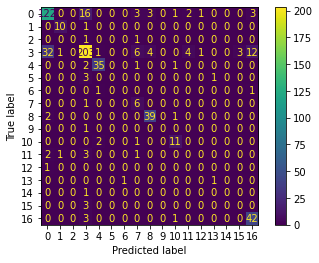

In [40]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test["Категория"])


# Сделаем предсказание для теста

In [41]:
df_test = pd.read_csv("./content/test_dataset_test.csv")

In [42]:
df_test['plain'] = df_test["Текст Сообщения"].apply(lambda str: cleanhtml(str))

In [43]:
df_test['text'] = df_test['plain'].map(lambda str: str.lower())
#df_test['text'] = df_test["text"].apply(lambda str: parse_date(str))
#df_test['text'] = df_test["text"].apply(lambda str: mark_numbers(str))

df_test['text'] = df_test['text'].apply(lambda str: mystem.lemmatize(str))
#df_test['text'] = df_test["text"].apply(lambda str: nltk.tokenize.word_tokenize(str))
#df_test['text'] = df_test['text'].apply(lambda str: [morph.parse(token)[0].normal_form for token in str])

#df_test['text'] = df_test["text"].apply(lambda str: nltk.tokenize.word_tokenize(str))

df_test['text'] = df_test['text'].map(lambda str: [token for token in str if token not in string.punctuation])

df_test['text'] = df_test['text'].map(lambda str: [token for token in str if token not in nltk.corpus.stopwords.words("russian")])

df_test['text'] = df_test['text'].map(lambda str: [token for token in str if token.isalpha()])

df_test['text'] = df_test['text'].map(lambda str:' '.join(str))

In [44]:
#bag_of_words_test = vectorizer.transform(df_test["text"])
bow1_test = vectorizer.transform(df_test["text"])
#df_cvect_test = pd.DataFrame(bag_of_words_test.toarray(), columns = feature_names)
Xtest = pd.DataFrame(bow1_test.toarray(), columns  = dic_vocabulary)


In [45]:
Xtest

,дорога,дорожный,светофор,яма,знак,переход,покрытие,пешеходный,дорожный покрытие,пешеходный переход,...,чаплыгина,чаплыгина км,черта курск,мусор лежать,бытовой строительный,дома улкарл,маркс свалка,сбоку дома,улкарл,улкарл маркс
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.345982,0.0,0.0,0.470361,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
testY = clf.predict(Xtest)

In [47]:
testY

array([[ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 8],
       [ 8],
       [ 3],
       [ 3],
       [ 3],
       [ 4],
       [10],
       [ 3],
       [ 3],
       [ 3],
       [16],
       [ 0],
       [ 8],
       [ 3],
       [16],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 3],
       [16],
       [ 3],
       [ 3],
       [10],
       [ 3],
       [16],
       [10],
       [ 0],
       [ 3],
       [ 8],
       [ 3],
       [ 0],
       [ 4],
       [ 0],
       [ 3],
       [16],
       [ 0],
       [ 3],
       [ 1],
       [ 8],
       [ 3],
       [ 7],
       [ 4],
       [ 0],
       [ 8],
       [ 3],
       [ 0],
       [ 8],
       [ 3],
       [ 3],
       [ 0],
       [ 8],
       [ 8],
       [ 1],
       [16],
       [ 0],
       [ 3],
       [ 8],
       [ 0],
       [ 1],
       [ 3],
       [ 3],
       [ 3],
       [16],
       [ 8],
       [ 3],
       [ 0],
       [16],
       [ 0],
       [16],
       [ 0],
       [ 0],
       [16],

In [48]:
submit_df=pd.DataFrame([[name, pred[0]] for name, pred in zip(df_test["id"], testY)], columns=["id", "Категория"])

In [49]:
submit_df

,id,Категория
0,843,3
1,1422,3
2,2782,3
3,2704,3
4,1,8
...,...,...
995,2619,16
996,2518,3
997,2524,0
998,1577,4


In [50]:
submit_df.to_csv("submit.csv", index=False)